### A simple take on Kaggle's Airbus Ship Detection Challenge

For more detailed explanations, please refer to Julián Peller excellent kernel series at:
https://www.kaggle.com/julian3833/3-basic-exploratory-analysis

In [1]:
# Import libraries
import os, PIL

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
plt.rcParams["patch.force_edgecolor"] = True
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

List Files in Directory

In [4]:
ls input/

sample_submission_v2.csv         train_ship_segmentations_v2.csv*
test_v2/                         train_v2/


In [5]:
# Read Data
df = pd.read_csv('input/train_ship_segmentations_v2.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
# Features Engineering - We will use EncodedPixels in a second DataFrame bellow
df['Ships'] = df['EncodedPixels'].notnull()
df = df.groupby('ImageId').sum().reset_index()
df['ShipPresent'] = df['Ships'] > 0

df.head()

,ImageId,Ships,ShipPresent
0,00003e153.jpg,0.0,False
1,0001124c7.jpg,0.0,False
2,000155de5.jpg,1.0,True
3,000194a2d.jpg,5.0,True
4,0001b1832.jpg,0.0,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192556 entries, 0 to 192555
Data columns (total 3 columns):
ImageId        192556 non-null object
Ships          192556 non-null float64
ShipPresent    192556 non-null bool
dtypes: bool(1), float64(1), object(1)
memory usage: 3.1+ MB


In [9]:
# Features Engineering - Second DataFrame with EncodedPixels and only images with ships

df_box = pd.read_csv('input/train_ship_segmentations_v2.csv')
df_box = df_box.dropna().groupby("ImageId")[['EncodedPixels']].agg(lambda rle_code: ' '.join(rle_code)).reset_index()
df_box['Path'] = df_box['ImageId'].apply(lambda filename: os.path.join('input/train_v2/', filename))
df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42556 entries, 0 to 42555
Data columns (total 3 columns):
ImageId          42556 non-null object
EncodedPixels    42556 non-null object
Path             42556 non-null object
dtypes: object(3)
memory usage: 997.5+ KB


In [10]:
df_box.head()

,ImageId,EncodedPixels,Path
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,input/train_v2/000155de5.jpg
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,input/train_v2/000194a2d.jpg
2,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,input/train_v2/00021ddc3.jpg
3,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,input/train_v2/0002756f7.jpg
4,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,input/train_v2/00031f145.jpg


In [11]:
def rle_to_pixels(rle_code):
    ''' This function decodes Run Lenght Encoding into pixels '''
    rle_code = [int(i) for i in rle_code.split()]
    
    pixels = [(pixel_position % 768, pixel_position // 768) 
              for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
              for pixel_position in range(start, start + length)]
        
    return pixels

def apply_mask(image, mask):
    ''' This function saturates the Red and Green RGB colors in the image 
        where the coordinates match the mask'''
    for x, y in mask:
        image[x, y, [0, 1, 2]] = (255, 255, 0)
    return image

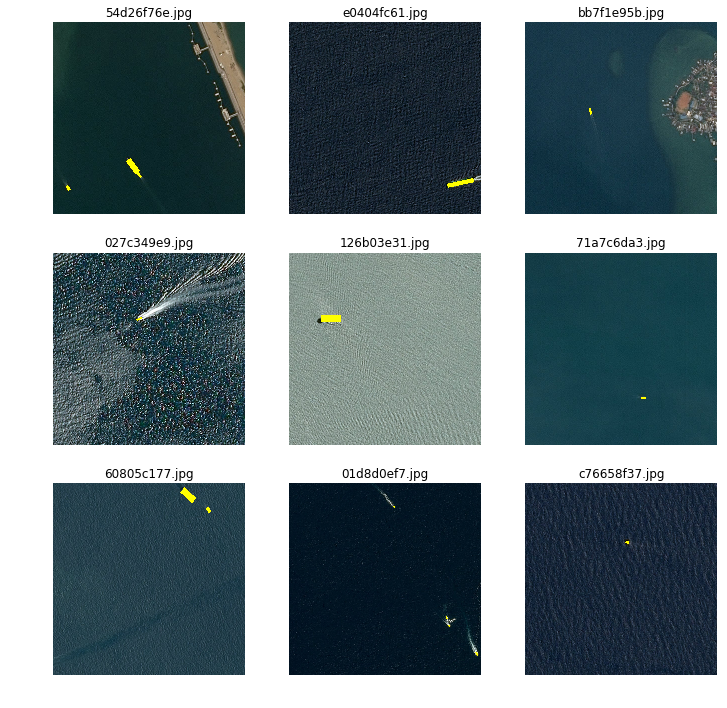

In [12]:
# Plots with masked ships on random images from the dataset

h, w = 3, 3
load_img = lambda path: np.array(PIL.Image.open(path))
fig, axes_list = plt.subplots(h, w, figsize=(4*h, 4*w))

for axes in axes_list:
    for ax in axes:
        ax.axis("off")
        path = np.random.choice(df_box['Path'])
        img = apply_mask(load_img(path), \
                rle_to_pixels(df_box[df_box['Path'] == path]['EncodedPixels'].iloc[0]))
        ax.imshow(img)
        ax.set_title(df_box[df_box['Path'] == path]['ImageId'].iloc[0])

In [13]:
df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42556 entries, 0 to 42555
Data columns (total 3 columns):
ImageId          42556 non-null object
EncodedPixels    42556 non-null object
Path             42556 non-null object
dtypes: object(3)
memory usage: 997.5+ KB


In [14]:
# Imbalanced Dataset | Ship/No-Ship Ratio

total_images = len(df)
ships = df['Ships'].sum()
ships_images = len(df[df['Ships'] > 0])
no_ship = total_images - ships_images

print(f"Images: {total_images} \nShips:  {ships}")
print(f"Images with ships:    {round(ships_images/total_images,2)} ({ships_images})")
print(f"Images with no ships: {round(no_ship/total_images,2)} ({no_ship})")

Images: 192556 
Ships:  81723.0
Images with ships:    0.22 (42556)
Images with no ships: 0.78 (150000)


In [15]:
# Engineering Features for the graphs

ship_ratio = df['ShipPresent'].value_counts()/total_images
ship_ratio = ship_ratio.rename(index={True:'Ship', False:'No Ship'})

total_ship_distribution = df['Ships'].value_counts()[1::]/ships_images

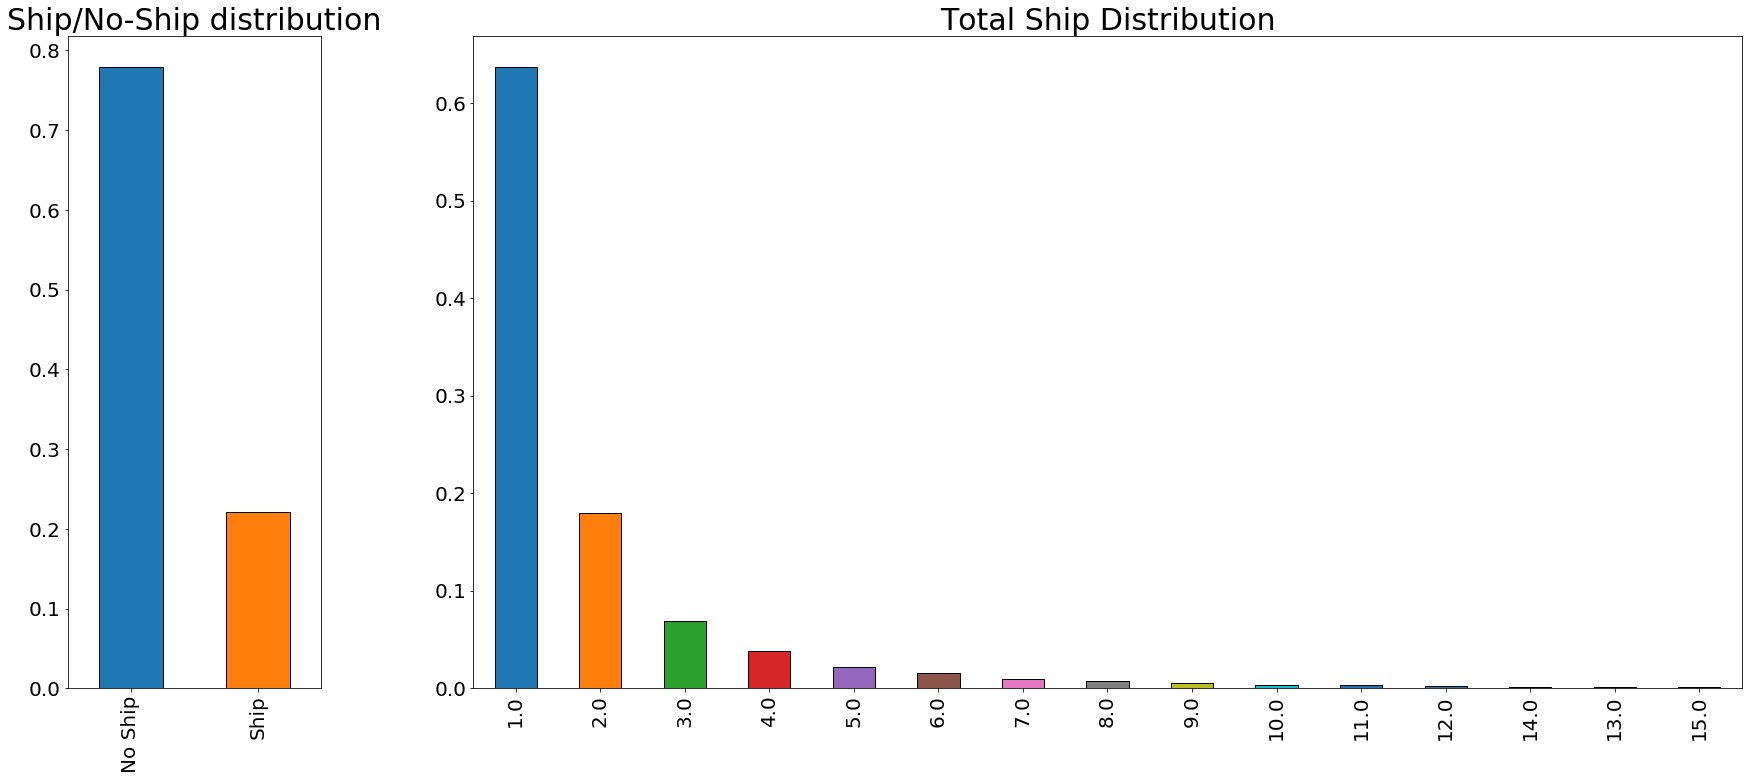

In [16]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), gridspec_kw={'width_ratios':[1,5]})

ship_ratio.plot.bar(ax=axes[0], title="Ship/No-Ship distribution")
total_ship_distribution.plot.bar(ax=axes[1], title="Total Ship Distribution")

axes[0].title.set_size(30)
axes[1].title.set_size(30)

In [18]:
# The operation bellow is expensive, if possible just load the pre-calculated dataset

# df_box['Pixels'] = df_box['EncodedPixels'].apply(rle_to_pixels).str.len() # EXPENSIVE
# df_box.to_csv('train_box_pixels_v2.csv', encoding='utf-8', index=False)
df_box = pd.read_csv('input/train_box_pixels_v2.csv')
df_box.head()

,ImageId,EncodedPixels,Path,Pixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,input/train_v2/000155de5.jpg,3388
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,input/train_v2/000194a2d.jpg,1460
2,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,input/train_v2/00021ddc3.jpg,1176
3,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,input/train_v2/0002756f7.jpg,408
4,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,input/train_v2/00031f145.jpg,425


In [19]:
# Imbalanced Dataset | Ship/No-Ship Pixels Ratio
# Due to the heavy imbalance of the dataset, we'll conduct our analysis only with ship images

n_images = df_box['ImageId'].nunique()
ship_pixels = df_box['Pixels'].sum()
total_pixels = n_images * 768 * 768
ratio = ship_pixels/total_pixels

print(f'Ship Pixels:   {round(ratio, 3)*100}%    ({ship_pixels})')
print(f'Total Pixels: {round(1 - ratio, 3)*100}% ({total_pixels - ship_pixels})')

Ship Pixels:   0.5%    (128092863)
Total Pixels: 99.5% (24972457281)


In [21]:
df.head()

,ImageId,Ships,ShipPresent
0,00003e153.jpg,0.0,False
1,0001124c7.jpg,0.0,False
2,000155de5.jpg,1.0,True
3,000194a2d.jpg,5.0,True
4,0001b1832.jpg,0.0,False


In [59]:
df['ShipPresentVector'] = df['ShipPresent'].map(lambda x: [0] if x == False else [1])
df['size_kb'] = df['ImageId'].apply(lambda img_id: \
                    round(os.stat(os.path.join("input/train_v2/", img_id)).st_size/1024))
df = df[df['size_kb'] > 50] # keep files larger than 50kb

In [60]:
print(df.size_kb.mean())
df.sample(5)

147.90030641163736


,ImageId,Ships,ShipPresent,ShipPresentVector,size_kb
64685,561c3e412.jpg,0.0,False,[0],198
110354,92ba6c294.jpg,0.0,False,[0],197
74593,6328d71f2.jpg,0.0,False,[0],114
115920,9a1f9c292.jpg,0.0,False,[0],156
35566,2f4b4eb7c.jpg,0.0,False,[0],116


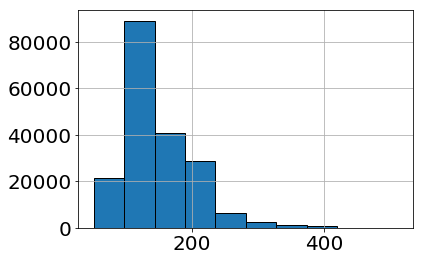

In [61]:
df.size_kb.hist()

In [63]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.3, stratify=df['Ships'])

In [64]:
 df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42556 entries, 0 to 42555
Data columns (total 4 columns):
ImageId          42556 non-null object
EncodedPixels    42556 non-null object
Path             42556 non-null object
Pixels           42556 non-null int64
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [65]:
df_box.head()

,ImageId,EncodedPixels,Path,Pixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,input/train_v2/000155de5.jpg,3388
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,input/train_v2/000194a2d.jpg,1460
2,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,input/train_v2/00021ddc3.jpg,1176
3,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,input/train_v2/0002756f7.jpg,408
4,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,input/train_v2/00031f145.jpg,425


In [67]:
train.head()

,ImageId,Ships,ShipPresent,ShipPresentVector,size_kb
105407,8c32a7f6c.jpg,0.0,False,[0],173
45057,3c1c731ca.jpg,1.0,True,[1],91
100961,86447059c.jpg,0.0,False,[0],110
21803,1d00f9a3a.jpg,0.0,False,[0],106
136630,b58aded8f.jpg,0.0,False,[0],116


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133872 entries, 105407 to 16479
Data columns (total 5 columns):
ImageId              133872 non-null object
Ships                133872 non-null float64
ShipPresent          133872 non-null bool
ShipPresentVector    133872 non-null object
size_kb              133872 non-null int64
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 5.2+ MB


In [72]:
train_df = pd.merge(df_box, train)

In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29379 entries, 0 to 29378
Data columns (total 8 columns):
ImageId              29379 non-null object
EncodedPixels        29379 non-null object
Path                 29379 non-null object
Pixels               29379 non-null int64
Ships                29379 non-null float64
ShipPresent          29379 non-null bool
ShipPresentVector    29379 non-null object
size_kb              29379 non-null int64
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 1.8+ MB
